In [1]:
import os
import sys
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np

os.chdir("/scratch/PI/rondror/docking-julia/notebooks")
from load_data import load_data

os.chdir("/scratch/PI/rondror/docking-julia/3_score_poses")
from fingerprint import FuzzyFingerPrint
from ligand import Ligand
from cluster import Cluster
from pose import Pose
from rmsd import RMSD

In [2]:
data_set_dir = '/scratch/PI/rondror/docking/data/B2AR/'   
   
rmsd_file = 'rmsd.csv'
ligands_dir = data_set_dir + 'ligands/'
grids_dir = data_set_dir + 'grids/'
glide_dir = data_set_dir + 'glide/'
crystal_fp_file = data_set_dir + 'crystal_fingers_output/B2AR_crystal_fingers.fp'#'crystalfifps/fuzzy_ifp.fp'
docking_fp_dir = data_set_dir + 'fifp/'#'glide_ifp/'

In [3]:
## useful class specifications:
# Ligand -- attributes: crystal (currently not used/none), poses (dict of pose_num:pose). methods: none.
# Pose -- attributes: rmsd (float), Fingerprint(), num (integer), gscore (float)
# FuzzyFingerPrint -- attributes: pdb (likely none), feats (dict of residue name:interaction list). methods: parser.

# crystals: maps structures to Poses, e.g., crystals['4LDO'] = Pose(rmsd=0, fingerprint, num=0, gscore=0)
# glides: maps ligand_struct, grid_struct to Ligands, e.g., glides['4LDO']['4LDO'] = Ligand(...)

(B2AR_crystals, B2AR_glides) = load_data(
    data_set_dir, rmsd_file, ligands_dir, grids_dir, glide_dir, crystal_fp_file, docking_fp_dir)

In [12]:
a = B2AR_glides['4QKX']['3SN6'].poses[0]
print a.fp.feats.keys() # available residue numbers
print a.fp.feats['199'] # sample fingerprint

['199', '195', '194', '191', '316', '193', '192', '114', '117', '110', '113', '174', '118', '289', '184', '185', '312', '286', '308', '200', '203', '204', '207', '190', '109', '169', '164', '106', '107', '293', '290']
[0.330457365615, 0.0, 0.0, 0.0, -0.22735076463, 0.0, 0.0]


In [25]:
## method 1: 
## input: residue number, interaction type
## output: fraction of poses the interaction occurs in

def interaction_counter(res_num, i_index, glides): # res_num should be a string, i_index is an integer
    total_poses = 0
    poses_with_interaction = 0
    for l_struct in glides.keys():
        for g_struct in glides.keys():
            for pose in glides[l_struct][g_struct].poses.keys():
                fp = glides[l_struct][g_struct].poses[pose].fp
                total_poses += 1
                if res_num in fp.feats and fp.feats[res_num][i_index] != 0:
                    poses_with_interaction += 1
    return float(poses_with_interaction)/total_poses
                

In [26]:
print interaction_counter('199',0,B2AR_glides)

0.473179852752


In [99]:
## method 2:
## input: pair of ligands, structures, pair_score function
## output: matrix with each row = a score type (see code), each column = a pair.

def simple_pair_score(fp1, fp2):
    score = 0
    for res in fp1.feats:
        if res in fp2.feats:
            ifp_size = len(fp1.feats[res])
            score += sum([fp1.feats[res][i]*fp2.feats[res][i] for i in range(ifp_size)]) # dot product
    return score

def compare_to_glide(l1, g1, l2, g2, glides, score_func):
    poses1 = glides[l1][g1].poses
    poses2 = glides[l2][g2].poses
    
    location = 0
    scored_poses = np.zeros((3,len(poses1)*len(poses2)))
    for i1 in poses1:
        for i2 in poses2:
            p1 = poses1[i1]
            p2 = poses2[i2]
            scored_poses[0][location] = p1.rmsd + p2.rmsd
            scored_poses[1][location] = p1.gscore + p2.gscore
            scored_poses[2][location] = score_func(p1.fp, p2.fp)
            location += 1
            
    #ranked_poses.sort(key=lambda x:x[0]) # sort on element 0 (the pair rmsd)
    return scored_poses            

In [100]:
def get_crystal_pair_with_most_shared_residues(glides):
    most_shared_residues = 0
    (s1b, s2b) = (None, None)
    for s1 in glides.keys():
        for s2 in glides.keys():
            if s1 != s2:
                fp1 = glides[s1][s1].poses[0].fp
                fp2 = glides[s2][s2].poses[0].fp
                num_r = len([i for i in fp1.feats if i in fp2.feats])
                if num_r > most_shared_residues:
                    most_shared_residues = num_r
                    (s1b, s2b) = (s1, s2)
    return (s1b, s2b)

In [105]:
print simple_pair_score(B2AR_crystals[s1b].fp, B2AR_crystals[s2b].fp) # sometimes very low -- not good

17.0


In [102]:
(s1b, s2b) = get_crystal_pair_with_most_shared_residues(B2AR_glides)
#scored_poses = compare_to_glide('4LDO','4LDO','3P0G','3P0G', B2AR_glides, simple_pair_score)
scored_poses = compare_to_glide(s1b, s1b, s2b, s2b, B2AR_glides, simple_pair_score)

In [104]:
print(s1b,s2b)

('3SN6', '3P0G')


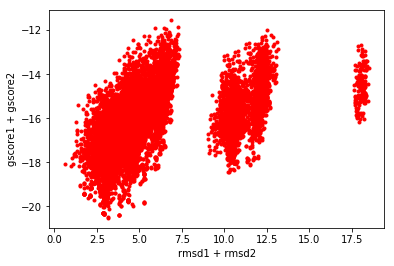

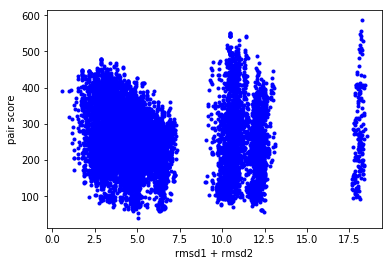

In [103]:
get_ipython().magic(u'matplotlib inline')

plt.plot(scored_poses[0][:], scored_poses[1][:],'r.')
plt.xlabel('rmsd1 + rmsd2')
plt.ylabel('gscore1 + gscore2')
plt.show()

plt.plot(scored_poses[0][:], scored_poses[2][:],'b.')
plt.xlabel('rmsd1 + rmsd2')
plt.ylabel('pair score')
plt.show()

# GOAL: if our fingerprints were working, pair score would be maximized when the rmsd = 0
#       (i.e., we want an inverse correlation in the second plot)